# Classification of Iris dataset

In [1]:
from sklearn.datasets import load_iris

In [2]:
iris_data = load_iris()

In [3]:
print(iris_data.keys())

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [4]:
N, D = iris_data.data.shape
print("Number of samples: ", N)
print("Number of features: ", D)

Number of samples:  150
Number of features:  4


In [5]:
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [6]:
import pandas as pd
iris = pd.DataFrame(iris_data.data)

In [7]:
iris.head()

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [8]:
iris.columns = iris_data.feature_names

In [9]:
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [10]:
iris['class'] = iris_data.target

In [11]:
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Classification is supervised learning in which the response is categorical
- "0": setosa
- "1": versicolor
- "2": virginica

In [12]:
class_names = ["setosa", "versicolor", 'virginica']

# Data preprocessing

In [13]:
# Load packages
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [14]:
import numpy as np
X = np.array(iris_data.data)
X = scaler.fit_transform(X)

In [15]:
Y = np.array(iris_data.target)

##### Split the dataset into train and test

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [18]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(105, 4) (45, 4) (105,) (45,)


## Data Loading

## Three steps
1. Define initialization method (\_\_init\_\_)
2. Define length method (\_\_len\_\_)
3. Define method to return one item on the index (\_\_getitem\_\_)

In [19]:
from torch.utils.data import Dataset

class ClassificationDataset(Dataset):
    def __init__(self, data, output):
        self.data = data
        self.output = output

    def __len__(self):
        return len(self.data)

    def __getitem__(self, ind):
        return self.data[ind], self.output[ind]

In [20]:
train_dataset = ClassificationDataset(X_train, Y_train)
test_dataset = ClassificationDataset(X_test, Y_test)

In [21]:
from torch.utils.data import DataLoader

In [22]:
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20)

# Define Model

In [23]:
import torch
from torch import nn
from torch.nn import functional as F

In [24]:
class ClassificationModel(nn.Module):
    def __init__(self, feature_dim, hidden_dim, output_dim):
        super(ClassificationModel, self).__init__()
        
        self.hidden1 = nn.Linear(feature_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.predict = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.predict(x)
        return x

In [25]:
hidden_dim = 10
output_dim = 3
model = ClassificationModel(D, hidden_dim, output_dim)

In [26]:
print(model)

ClassificationModel(
  (hidden1): Linear(in_features=4, out_features=10, bias=True)
  (hidden2): Linear(in_features=10, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=3, bias=True)
)


In [27]:
from draw_neural_net import draw_neural_net
from matplotlib import pyplot as plt
# %matplotlib inline

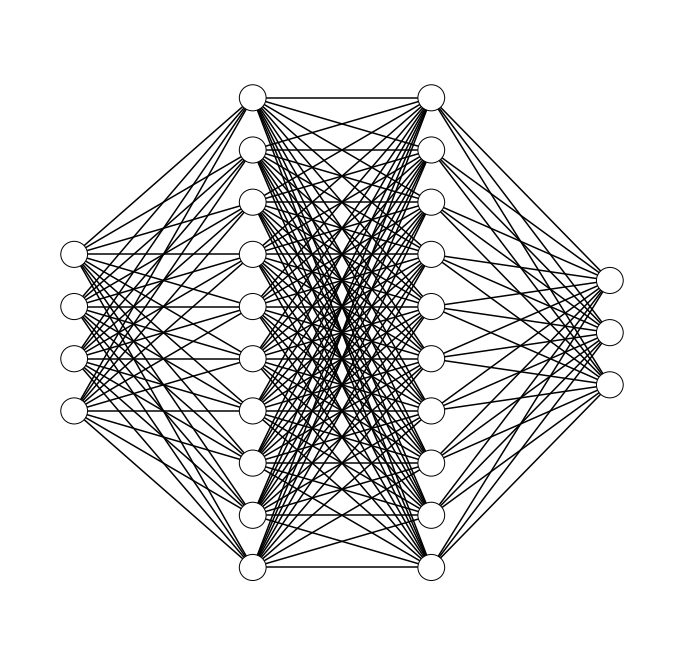

In [28]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, np.array([D, hidden_dim, hidden_dim, output_dim]).astype(int))
plt.show()

# Training Strategy

- We need Loss function to compute the prediction error
- and an optimization function to update the parameter

##### Let's define values to setup training process

In [29]:
num_epochs = 100 
lr = 0.01

In [30]:
criterion = torch.nn.CrossEntropyLoss() # log_softmax and NLL loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [31]:
from tqdm import trange

In [32]:
# Training loop
losses = []
epochs = trange(num_epochs, desc="Training Loss")
for epoch in epochs:
    running_loss = 0
    for data in train_loader:
        # get the data
        inputs, outputs = data
        inputs = inputs.float()
        outputs = outputs.long()
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass: Calculate predicted price by passing x to the model
        y_pred = model(inputs)
        # compute loss
        loss = criterion(y_pred, outputs)
        running_loss += loss.item()
        # perform backward pass and update the parameters
        loss.backward()
        optimizer.step()
    
    epochs.set_description("Training_loss: %g" % running_loss)
    losses.append(running_loss)

Training_loss: 0.0869652: 100%|██████████| 100/100 [00:00<00:00, 110.90it/s]


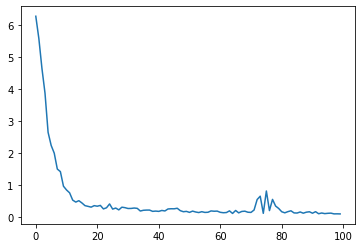

In [33]:
plt.plot(losses)
plt.show()

#### Evaluate the model

In [34]:
with torch.no_grad():
    model.eval()
    
    preds = []
    for data in test_loader:
        # get the data
        inputs, outputs = data
        inputs = inputs.type(torch.FloatTensor)
        outputs = outputs.type(torch.FloatTensor)
        
        pred = model(inputs)
        preds.append(pred.numpy())

    prediction = np.concatenate(preds)

In [35]:
Y_pred = np.argmax(prediction, 1)

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(Y_pred, Y_test))

0.9333333333333333


In [37]:
conf_mat = confusion_matrix(Y_pred, Y_test)

In [38]:
from cm import print_confusion_matrix

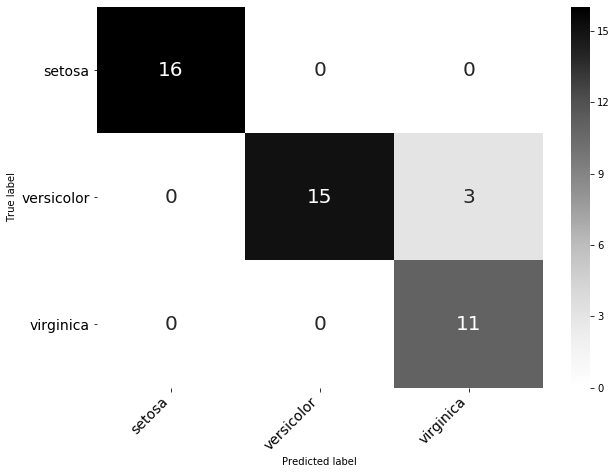

In [39]:
fig = print_confusion_matrix(conf_mat, class_names)
plt.show()